In [17]:
import librosa
from IPython.display import Audio
import matplotlib.pyplot as plt
import torchaudio
import torch
from torch import nn
from torch import Tensor
from torchsummary import summary

In [26]:
hop_length = 512
SAMPLE_RATE = 44100
# Create mel spectogram function
mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=hop_length,
    n_mels=64
)
# Transform multiple channels to one through taking the mean
def _mix_down_if_necessary(signal):
    if signal.shape[0] > 1:
        signal = torch.mean(signal, dim=0, keepdim=True)
    return signal
# Classify audio sample
def classify_audio(audio):
    # fall_spec = _mix_down_if_necessary(signal=audio)
    fall_spec = mel(audio)
    fall_spec = fall_spec[None,:]
    pred = None
    with torch.no_grad():
        pred = cnn(fall_spec)
    return torch.max(pred, 1)
# Plot audio
def plot_audio(audio, sr):
    mixed = _mix_down_if_necessary(audio)
    waveform = mixed.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(time_axis, waveform[0], linewidth=1)
    axs[0].grid(True)
    axs[0].set_title("Waveform")
    axs[1].set_title("Spectrogram (db)")
    axs[1].set_ylabel("freq_bin")
    axs[1].set_xlabel("frame")
    im = axs[1].imshow(librosa.power_to_db(mel(mixed)[0]), origin="lower", aspect="auto",cmap='magma')
    fig.colorbar(im, ax=axs[1])
    fig.set_size_inches(20, 5)
    plt.show(block=False)

In [21]:
import librosa
import matplotlib.pyplot as plt
#from IPython.display import Audio
def plot_spectrogram(audio, audio0, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 2)
    axs[0].set_title("44.1 kHz Spectrogram (db)")
    axs[0].set_ylabel(ylabel)
    axs[0].set_xlabel("frame")
    im = axs[0].imshow(librosa.power_to_db(audio.cpu()), origin="lower", aspect="auto")

    axs[1].set_title("22.05 kHz Spectrogram (db)")
    axs[1].set_ylabel(ylabel)
    axs[1].set_xlabel("frame")
    im0 = axs[1].imshow(librosa.power_to_db(audio0.cpu()), origin="lower", aspect="auto")
    fig.set_size_inches(12, 4)
    fig.colorbar(im0, ax=axs)
    plt.show(block=False)


In [22]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=44100,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)
mel_spectrogram0 = torchaudio.transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

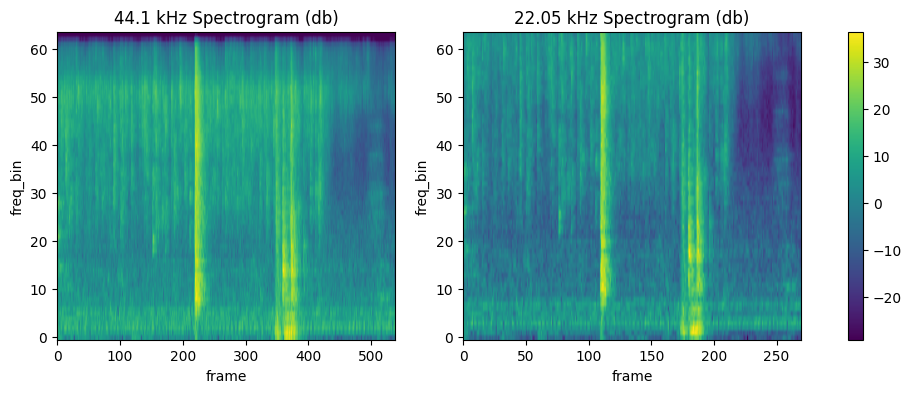

In [8]:
signal, sr = torchaudio.load('Long Falls/bath-long_fall_6.wav')
resample = torchaudio.transforms.Resample(sr, 22050)
signal0 = resample(signal)
plot_spectrogram(mel_spectrogram(signal)[0], mel_spectrogram0(signal0)[0])

# Audio data samples
Collected audio data has been categorised up into ambient and fall samples. Here is an ambient file.

In [9]:
ambient, sr = torchaudio.load('fold0/ambient-fall_10_1.wav')
Audio(data=ambient, rate=sr)

The waveform and mel spectogram are shown below

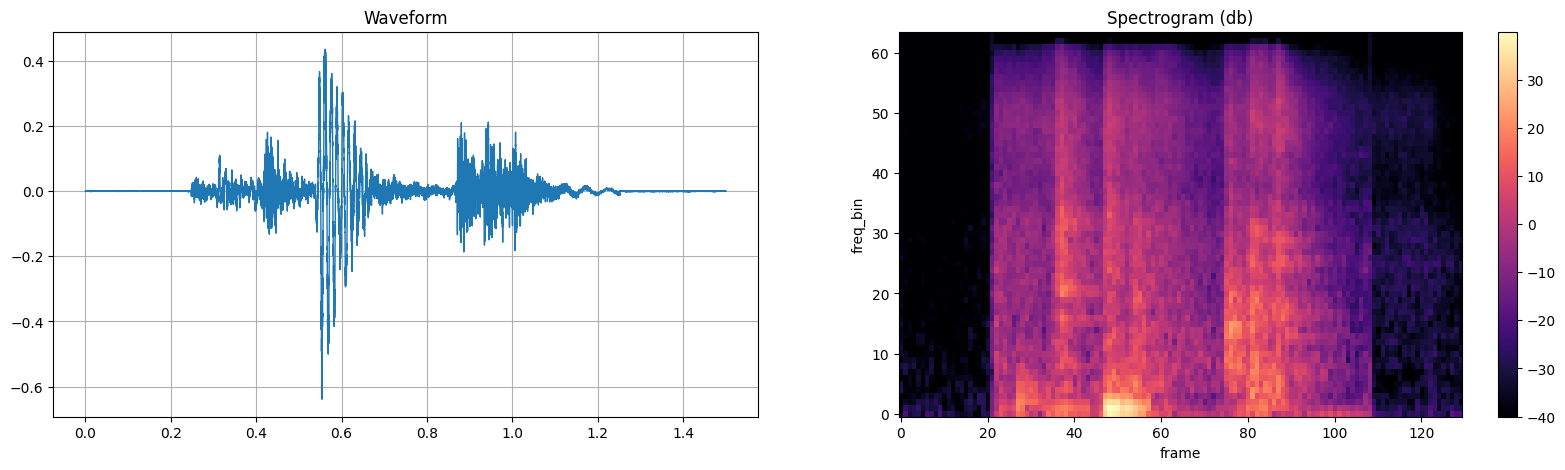

In [10]:
plot_audio(ambient, sr)

In [11]:
pambient, asr = torchaudio.load('fold0/quiet-fall_10_1.wav')
Audio(data=pambient, rate=asr)

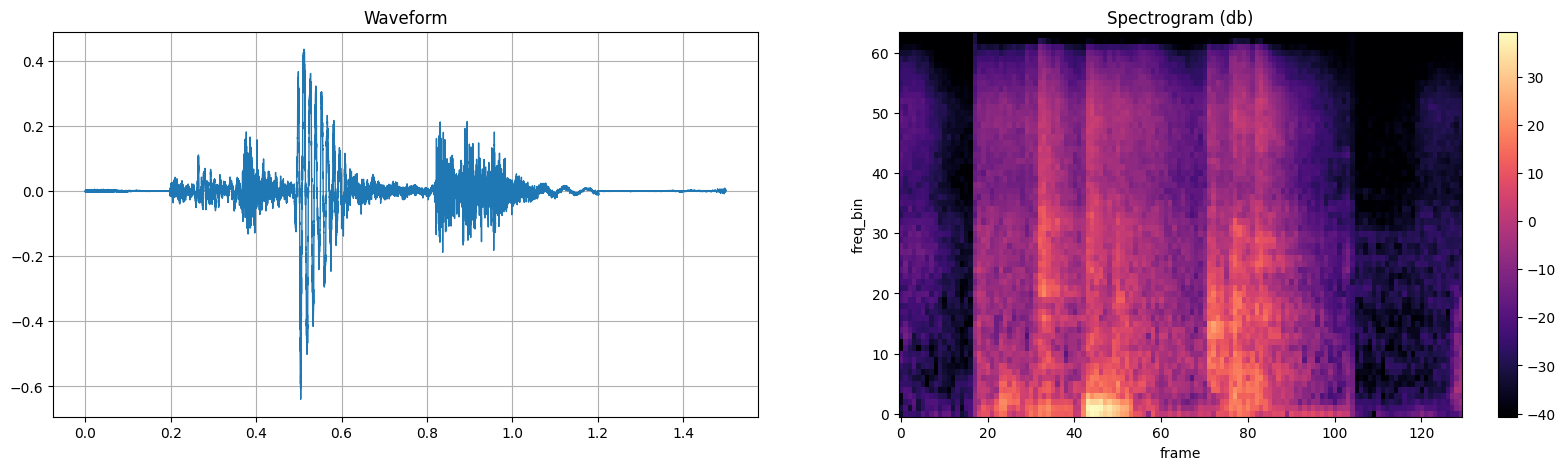

In [12]:
plot_audio(pambient, sr)

We now follow the same process for a fall clip

In [14]:
fall, fsr = torchaudio.load('fold0/quiet-fall_10_1.wav')
Audio(data=fall, rate=fsr)

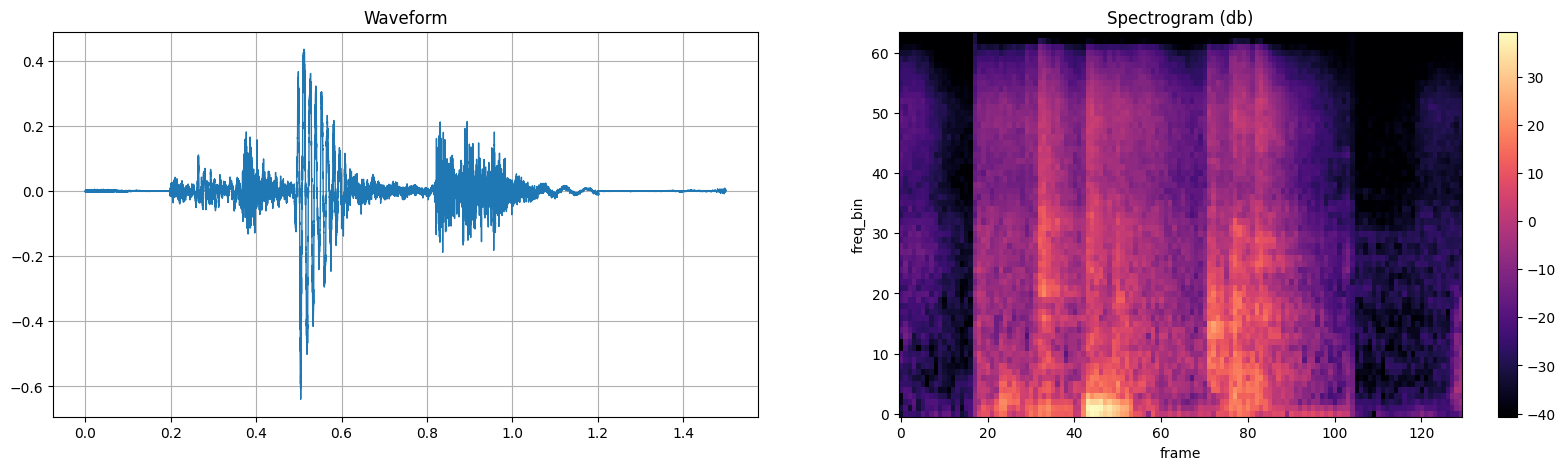

In [15]:
plot_audio(fall, fsr)

In [ ]:
pfall, fsr = torchaudio.load('fold0/quiet-fall_10_1.wav')
Audio(data=pfall, rate=fsr)

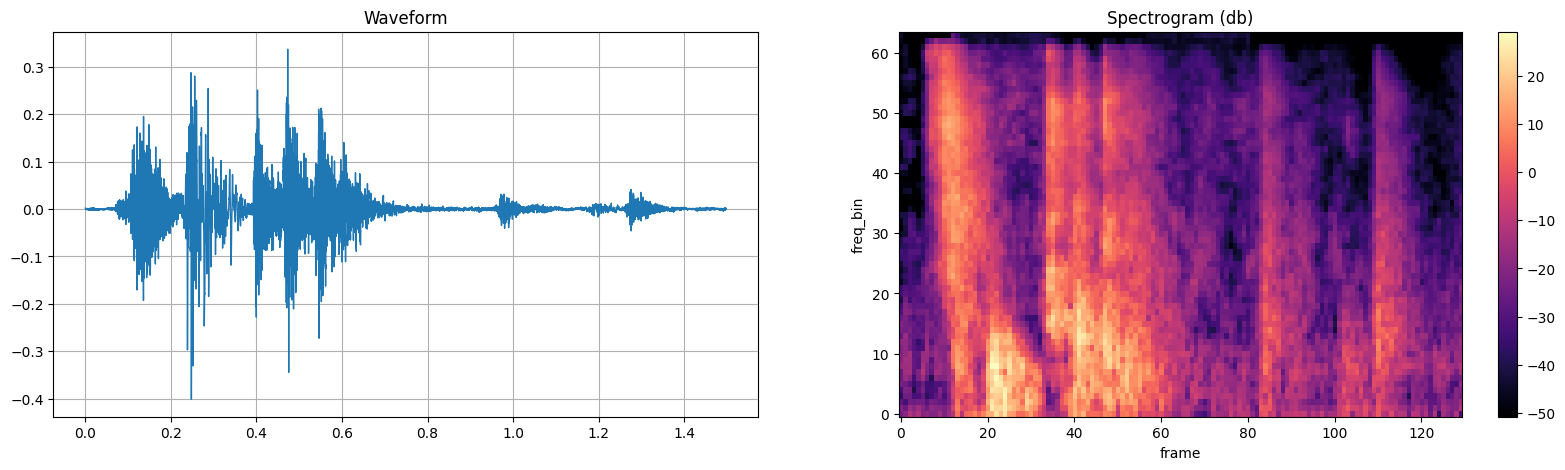

In [42]:
plot_audio(pfall, fsr)

# Classification of previous audio samples
We used the percussive audio samples for training so for more accurate results we use them to classify fall vs non fall sounds.
When we classify the sounds, we get an index that we must map to the correct labels.

In [29]:
map = ["No fall", "Fall"]

In [30]:
map[classify_audio(pambient).indices[0]]

'No fall'

In [28]:
map[classify_audio(pfall).indices[0]]

NameError: name 'pfall' is not defined

When a fall occurs, we want to be able to notify an emergency contact, we can do so through sending them a text.

In [46]:
from twilio.rest import Client
import os
from dotenv import load_dotenv
load_dotenv()

account_sid = os.environ["TWILACC"]
auth_token = os.environ["TWILAUTH"]
client = Client(account_sid, auth_token)

message = client.messages.create(
                              messaging_service_sid='MG574bc93dd1ae401764a064ccd00a762a',
                              body='Fall has occurred',
                              to='+15875906624'
                          )

print(message.sid)

SM2c08d128cc0c729124339b2aa7de5878


# Appendix:

### Helper functions

### Convolutional Neural Network
Below is the structure of the convolutional neural network used for our model

In [ ]:
class BCNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(
                num_features = 16,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(
                num_features = 32,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(
                num_features = 64,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(

            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(
                num_features = 128,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(3200*2, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions

device = torch.device("cpu")
# cnn = CNNNetwork()
cnn = torch.load('best-model-bn.pth',map_location=device)
cnn.eval()

In [18]:
class ConvBlock(nn.Module):
    # Convolution Block with Conv2d layer, Batch Normalization and ReLU. Act is an activation function.
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            stride: int,
            act=nn.ReLU(),
            groups=1,
            bn=True,
            bias=False
    ):
        super().__init__()

        # If k = 1 -> p = 0, k = 3 -> p = 1, k = 5, p = 2.
        padding = kernel_size // 2
        self.c = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups,
                           bias=bias)
        self.bn = nn.BatchNorm2d(out_channels) if bn else nn.Identity()
        self.act = act

    def forward(self, x: Tensor) -> Tensor:
        return self.act(self.bn(self.c(x)))


class SeBlock(nn.Module):
    # Squeeze and Excitation Block.
    def __init__(
            self,
            in_channels: int
    ):
        super().__init__()

        C = in_channels
        r = C // 4
        self.globpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(C, r, bias=False)
        self.fc2 = nn.Linear(r, C, bias=False)
        self.relu = nn.ReLU()
        self.hsigmoid = nn.Hardsigmoid()

    def forward(self, x: Tensor) -> Tensor:
        # x shape: [N, C, H, W].
        f = self.globpool(x)
        f = torch.flatten(f, 1)
        f = self.relu(self.fc1(f))
        f = self.hsigmoid(self.fc2(f))
        f = f[:, :, None, None]
        # f shape: [N, C, 1, 1]

        scale = x * f
        return scale


# BNeck
class BNeck(nn.Module):
    # MobileNetV3 Block
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            exp_size: int,
            se: bool,
            act: torch.nn.modules.activation,
            stride: int
    ):
        super().__init__()

        self.add = in_channels == out_channels and stride == 1

        self.block = nn.Sequential(
            ConvBlock(in_channels, exp_size, 1, 1, act),
            ConvBlock(exp_size, exp_size, kernel_size, stride, act, exp_size),
            SeBlock(exp_size) if se == True else nn.Identity(),
            ConvBlock(exp_size, out_channels, 1, 1, act=nn.Identity())
        )

    def forward(self, x: Tensor) -> Tensor:
        res = self.block(x)
        if self.add:
            res = res + x

        return res


""" MobileNetV3 """


class MobileNetV3(nn.Module):
    def __init__(
            self,
            config_name: str,
            in_channels=3,
            classes=2
    ):
        super().__init__()
        config = self.config(config_name)

        # First convolution(conv2d) layer.
        self.conv = ConvBlock(in_channels, 16, 3, 2, nn.Hardswish())
        # Bneck blocks in a list.
        self.blocks = nn.ModuleList([])
        for c in config:
            kernel_size, exp_size, in_channels, out_channels, se, nl, s = c
            self.blocks.append(BNeck(in_channels, out_channels, kernel_size, exp_size, se, nl, s))

        # Classifier
        last_outchannel = config[-1][3]
        last_exp = config[-1][1]
        out = 1280 if config_name == "large" else 1024
        self.classifier = nn.Sequential(
            ConvBlock(last_outchannel, last_exp, 1, 1, nn.Hardswish()),
            nn.AdaptiveAvgPool2d((1, 1)),
            ConvBlock(last_exp, out, 1, 1, nn.Hardswish(), bn=False, bias=True),
            nn.Dropout(0.8),
            nn.Conv2d(out, classes, 1, 1)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        for block in self.blocks:
            x = block(x)

        x = self.classifier(x)
        return torch.flatten(x, 1)

    def config(self, name):
        HE, RE = nn.Hardswish(), nn.ReLU()
        # [kernel, exp size, in_channels, out_channels, SEBlock(SE), activation function(NL), stride(s)]
        large = [
            [3, 16, 16, 16, False, RE, 1],
            [3, 64, 16, 24, False, RE, 2],
            [3, 72, 24, 24, False, RE, 1],
            [5, 72, 24, 40, True, RE, 2],
            [5, 120, 40, 40, True, RE, 1],
            [5, 120, 40, 40, True, RE, 1],
            [3, 240, 40, 80, False, HE, 2],
            [3, 200, 80, 80, False, HE, 1],
            [3, 184, 80, 80, False, HE, 1],
            [3, 184, 80, 80, False, HE, 1],
            [3, 480, 80, 112, True, HE, 1],
            [3, 672, 112, 112, True, HE, 1],
            [5, 672, 112, 160, True, HE, 2],
            [5, 960, 160, 160, True, HE, 1],
            [5, 960, 160, 160, True, HE, 1]
        ]

        small = [
            [3, 16, 16, 16, True, RE, 2],
            [3, 72, 16, 24, False, RE, 2],
            [3, 88, 24, 24, False, RE, 1],
            [5, 96, 24, 40, True, HE, 2],
            [5, 240, 40, 40, True, HE, 1],
            [5, 240, 40, 40, True, HE, 1],
            [5, 120, 40, 48, True, HE, 1],
            [5, 144, 48, 48, True, HE, 1],
            [5, 288, 48, 96, True, HE, 2],
            [5, 576, 96, 96, True, HE, 1],
            [5, 576, 96, 96, True, HE, 1]
        ]

        if name == "large": return large
        if name == "small": return small


device = torch.device("cpu")
cnn = MobileNetV3("small")
cnn.load_state_dict(torch.load("3ch_mn3_f0_e12.pth",map_location=device))

<All keys matched successfully>